## Reference Model

In [1]:
import maxentep
import maxent
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.stats as ss
plt.style.use('seaborn-darkgrid')
# disabling gpu for now
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
M = 4
R = np.abs(np.random.normal(size=(M,M), loc=1.25))
R = R / np.sum(R, axis=1).reshape(M,1)
R, np.sum(R, axis=1)

(array([[0.12342813, 0.10975778, 0.30663227, 0.46018183],
        [0.36306116, 0.27278869, 0.30449681, 0.05965334],
        [0.03180488, 0.4881419 , 0.2097457 , 0.27030752],
        [0.26332161, 0.28233973, 0.17235292, 0.28198574]]),
 array([1., 1., 1., 1.]))

In [3]:
# compartment parameters
compartments = ['E', 'A', 'I', 'R']
infections_compartments = [1,2]
C = len(compartments)
tmat = maxentep.TransitionMatrix(compartments, infections_compartments)
tmat.add_transition('E', 'A', 7, 0)
tmat.add_transition('A', 'I', 3, 0)
tmat.add_transition('I', 'R', 14, 0)

In [4]:
start = np.zeros((M, C))
start[0, 0] = 0.1

In [6]:
infect = maxentep.contact_infection_func(infections_compartments)
model = maxentep.MetaModel(infect, 250)

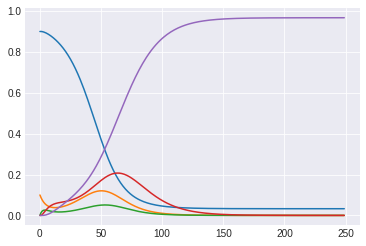

In [8]:
beta = np.array([0.02, 0.02])
ref_traj = model(R, tmat.value, start, beta)[0]
plt.plot(ref_traj[:,0])

## Sample SEIR Trajectories 

Use different compartment dist

In [20]:
# compartment parameters
compartments = ['E', 'I', 'R']
infections_compartments = [1]
C = len(compartments)
tmat = maxentep.TransitionMatrix(compartments, infections_compartments)
tmat.add_transition('E', 'I', 6, 3)
tmat.add_transition('I', 'R', 10, 4)

In [21]:
hyper_pram = maxentep.ParameterHypers()
hyper_pram.beta_low = [0.005]*2
hyper_pram.beta_high = [0.05]*2
hyper_pram.beta_var = [0.1]*2
param_model = maxentep.MetaParameterJoint(np.zeros((M,)), R * 0.9, tmat, name='unbiased_model', n_infectious_compartments=1, hypers = hyper_pram)

In [22]:
import tqdm
#tf.debugging.enable_check_numerics()
N = 512
batches = 16
total_batches = N * batches
time = 250
outs = []
infect = maxentep.contact_infection_func(infections_compartments)
model = maxentep.MetaModel(infect, time)
for b in tqdm.tqdm(range(batches)):
    ps = param_model.sample(N)
    outs.append(model(*ps))
trajs = np.concatenate(outs, axis=0)
print(trajs.shape)

100%|██████████| 16/16 [00:17<00:00,  1.08s/it]

(8192, 250, 4, 4)


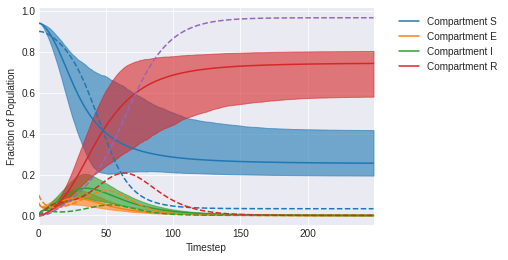

In [23]:
full_compartments = ['S'] + compartments
maxentep.traj_quantile(trajs[:,:,0,:], names=full_compartments, plot_means=True)
plt.plot(ref_traj[:,0], linestyle='--')
plt.show()


## Make restraints from reference trajectory


Using only first half of trajectory and use the R compartment in patch 0

In [24]:
npoints = 5
prior = maxent.Laplace(0.1)
# prior = maxent.EmptyPrior() # can try empty to compare with regressed
restraints, plot_fxns = maxentep.traj_to_restraints(ref_traj[:125,:,:], [0, -1], npoints, prior, noise=0.02)

101 0.87050915 0.8694795902117869
52 0.3117063 0.3162726893732585
38 0.16754015 0.1723436876488578
24 0.07904575 0.08026520102456854
115 0.9220201 0.9046099571809393


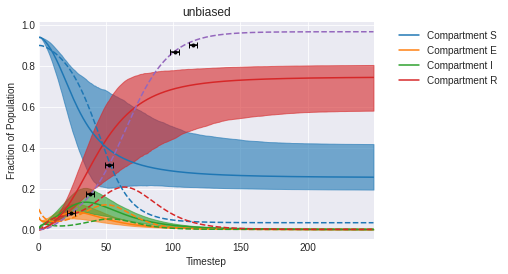

In [25]:
maxentep.traj_quantile(trajs[:,:,0,:], names=full_compartments, plot_means=True)
plt.title('unbiased')
plt.plot(ref_traj[:,0], linestyle='--')
for i,pf in enumerate(plot_fxns):
    pf(plt.gca(), 0)
plt.show()

In [30]:
me_model = maxent.MaxentModel(restraints)
me_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), 'mean_squared_error')

In [31]:
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self. i = 0
    def on_epoch_begin(self, epoch, logs=None):
        self.i += 1
        return self.i

In [32]:
history = me_model.fit(trajs, batch_size=total_batches,epochs=100, callbacks=[CustomCallback()])

Epoch 1/100
1/1 [==============================] - 0s 741us/step - loss: 37.6385 - weight-entropy: 0.3217
Epoch 2/100
1/1 [==============================] - 0s 487us/step - loss: 37.5058 - weight-entropy: 0.3391
Epoch 3/100
1/1 [==============================] - 0s 465us/step - loss: 37.3574 - weight-entropy: 0.3604
Epoch 4/100
1/1 [==============================] - 0s 448us/step - loss: 37.1903 - weight-entropy: 0.3859
Epoch 5/100
1/1 [==============================] - 0s 418us/step - loss: 37.0006 - weight-entropy: 0.4162
Epoch 6/100
1/1 [==============================] - 0s 565us/step - loss: 36.7833 - weight-entropy: 0.4519
Epoch 7/100
1/1 [==============================] - 0s 455us/step - loss: 36.5359 - weight-entropy: 0.4939
Epoch 8/100
1/1 [==============================] - 0s 462us/step - loss: 36.2468 - weight-entropy: 0.5429
Epoch 9/100
1/1 [==============================] - 0s 434us/step - loss: 35.9141 - weight-entropy: 0.6003
Epoch 10/100
1/1 [============================

1/1 [==============================] - 0s 529us/step - loss: 0.0476 - weight-entropy: 8.6308
Epoch 79/100
1/1 [==============================] - 0s 435us/step - loss: 0.0470 - weight-entropy: 8.6318
Epoch 80/100
1/1 [==============================] - 0s 437us/step - loss: 0.0464 - weight-entropy: 8.6329
Epoch 81/100
1/1 [==============================] - 0s 482us/step - loss: 0.0459 - weight-entropy: 8.6338
Epoch 82/100
1/1 [==============================] - 0s 454us/step - loss: 0.0454 - weight-entropy: 8.6347
Epoch 83/100
1/1 [==============================] - 0s 448us/step - loss: 0.0449 - weight-entropy: 8.6356
Epoch 84/100
1/1 [==============================] - 0s 503us/step - loss: 0.0444 - weight-entropy: 8.6364
Epoch 85/100
1/1 [==============================] - 0s 504us/step - loss: 0.0440 - weight-entropy: 8.6372
Epoch 86/100
1/1 [==============================] - 0s 447us/step - loss: 0.0436 - weight-entropy: 8.6380
Epoch 87/100
1/1 [==============================] - 0s 489u

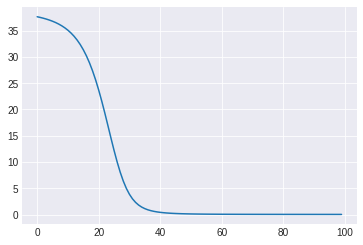

In [33]:
plt.plot(history.history['loss'])

## Using Algorithm 2

In [75]:
fit_param_model = maxentep.MetaParameterJoint(np.zeros((M,)), R, tmat, name='unbiased_model', n_infectious_compartments=1)
fit_param_model.compile(tf.optimizers.Adam(0.01))
# fit_param_model.compile(tf.optimizers.SGD(0.1))
hme_model = maxent.HyperMaxentModel(restraints, fit_param_model, model)
# hme_model.compile(tf.keras.optimizers.SGD(learning_rate=0.1), 'mean_squared_error')
hme_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-3), 'mean_squared_error')                                                                          

In [76]:
history = hme_model.fit(N, final_batch_multiplier=batches, outter_epochs=3, batch_size=N*batches, epochs=16)

Epoch 1/16
1/1 [==============================] - 0s 716us/step - loss: 0.1772 - weight-entropy: 5.9336
Epoch 2/16
1/1 [==============================] - 0s 451us/step - loss: 0.1746 - weight-entropy: 5.9307
Epoch 3/16
1/1 [==============================] - 0s 447us/step - loss: 0.1721 - weight-entropy: 5.9278
Epoch 4/16
1/1 [==============================] - 0s 439us/step - loss: 0.1695 - weight-entropy: 5.9249
Epoch 5/16
1/1 [==============================] - 0s 445us/step - loss: 0.1670 - weight-entropy: 5.9219
Epoch 6/16
1/1 [==============================] - 0s 446us/step - loss: 0.1645 - weight-entropy: 5.9189
Epoch 7/16
1/1 [==============================] - 0s 437us/step - loss: 0.1620 - weight-entropy: 5.9159
Epoch 8/16
1/1 [==============================] - 0s 441us/step - loss: 0.1595 - weight-entropy: 5.9129
Epoch 9/16
1/1 [==============================] - 0s 443us/step - loss: 0.1571 - weight-entropy: 5.9098
Epoch 10/16
1/1 [==============================] - 0s 432us/step

16/16 [==============================] - 0s 1ms/step - loss: -0.1237 - R-dist-dist_loss: -0.0057 - T-dist-dist_loss: -0.0060 - rho-dist-dist_loss: -0.0029 - beta-dist_loss: -0.1092
Epoch 7/16
16/16 [==============================] - 0s 1ms/step - loss: -0.1237 - R-dist-dist_loss: -0.0056 - T-dist-dist_loss: -0.0060 - rho-dist-dist_loss: -0.0029 - beta-dist_loss: -0.1092
Epoch 8/16
16/16 [==============================] - 0s 1ms/step - loss: -0.1238 - R-dist-dist_loss: -0.0056 - T-dist-dist_loss: -0.0060 - rho-dist-dist_loss: -0.0029 - beta-dist_loss: -0.1092
Epoch 9/16
16/16 [==============================] - 0s 1ms/step - loss: -0.1237 - R-dist-dist_loss: -0.0056 - T-dist-dist_loss: -0.0060 - rho-dist-dist_loss: -0.0029 - beta-dist_loss: -0.1092
Epoch 10/16
16/16 [==============================] - 0s 1ms/step - loss: -0.1238 - R-dist-dist_loss: -0.0057 - T-dist-dist_loss: -0.0060 - rho-dist-dist_loss: -0.0029 - beta-dist_loss: -0.1092
Epoch 11/16
16/16 [==============================]

In [77]:
history.history.keys()

dict_keys(['loss', 'weight-entropy', 'prior-loss', 'prior-R-dist-dist_loss', 'prior-T-dist-dist_loss', 'prior-rho-dist-dist_loss', 'prior-beta-dist_loss'])

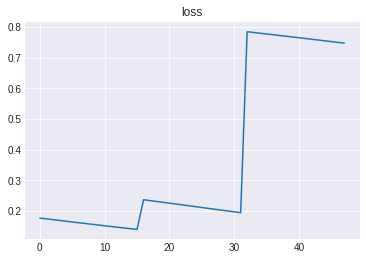

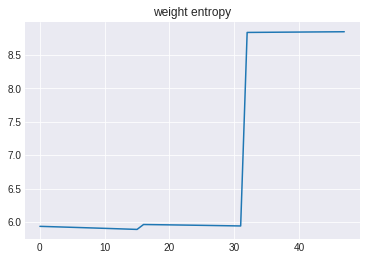

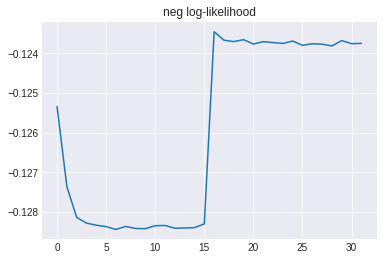

In [78]:
plt.plot(history.history['loss'])
plt.title('loss')
plt.show()

plt.plot(history.history['weight-entropy'])
plt.title('weight entropy')
plt.show()

plt.plot(history.history['prior-loss'])
plt.title('neg log-likelihood')
plt.show()

In [79]:
fit_param_model.get_layer('beta').trainable_variables,param_model.get_layer('beta').trainable_variables

([<tf.Variable 'beta/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-2.5638611]], dtype=float32)>],
 [<tf.Variable 'beta/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-2.3025851]], dtype=float32)>])

In [80]:
fit_param_model.summary()

Model: "unbiased_model-model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
R-dist-hypers (TrainableInputLa (None, 2, 4, 4)      32          input_9[0][0]                    
__________________________________________________________________________________________________
R-dist-jitter (Lambda)          (None, 2, 4, 4)      0           R-dist-hypers[0][0]              
__________________________________________________________________________________________________
T-dist-hypers (TrainableInputLa (None, 2, 3, 3)      18          input_9[0][0]                    
_______________________________________________________________________________

In [81]:
fit_param_model.get_layer('rho-dist-start-logit-hypers').trainable_variables,param_model.get_layer('rho-dist-start-logit-hypers').trainable_variables

([<tf.Variable 'value:0' shape=(4,) dtype=float32, numpy=array([-0.5149408 ,  0.06141986,  0.2770445 ,  0.10193344], dtype=float32)>],
 [<tf.Variable 'value:0' shape=(4,) dtype=float32, numpy=array([0., 0., 0., 0.], dtype=float32)>])

In [82]:
hme_fit = np.sum((hme_model.restraint_values * hme_model.traj_weights[:,np.newaxis]), axis=0)
me_fit =  np.sum((me_model.restraint_values * me_model.traj_weights[:,np.newaxis]), axis=0)
print(hme_fit, me_fit)
print(np.mean(hme_fit**2), np.mean(me_fit**2))

[0.05690221 0.88925403 1.2198093  1.1994168  0.02503475] [-0.10992076  0.053562   -0.02875325 -0.41730142 -0.09242926]
0.7442345 0.03969237


In [83]:
eh = -np.sum(hme_model.traj_weights * np.log(hme_model.traj_weights))
e =  -np.sum(me_model.traj_weights * np.log(me_model.traj_weights))
print('Maxent', e, 'after tuning', eh)

Maxent 8.647074 after tuning 8.847873


## Direct Regression of Model

In [43]:
T = tmat.value
start = np.zeros((M, C))
start[0,0] = 0.5
infect = maxentep.ContactInfectionLayer(0.1, infections_compartments)
# make "agreement" function
def agreement(traj, rs=restraints):
    s = 0
    for r in rs:
        s += r(traj[0])**2
    return s
rmodel = maxentep.TrainableMetaModel(start, R, T, infect, 250, agreement)

In [44]:
rmodel.compile(optimizer=tf.keras.optimizers.Adam(0.01))
utraj = rmodel.get_traj()
rmodel.fit(100)
rtraj = rmodel.get_traj()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().
100/100 [==============================] - 7s 68ms/step - loss: 0.5884 - output_2_loss: 0.5884


## Now visualize results

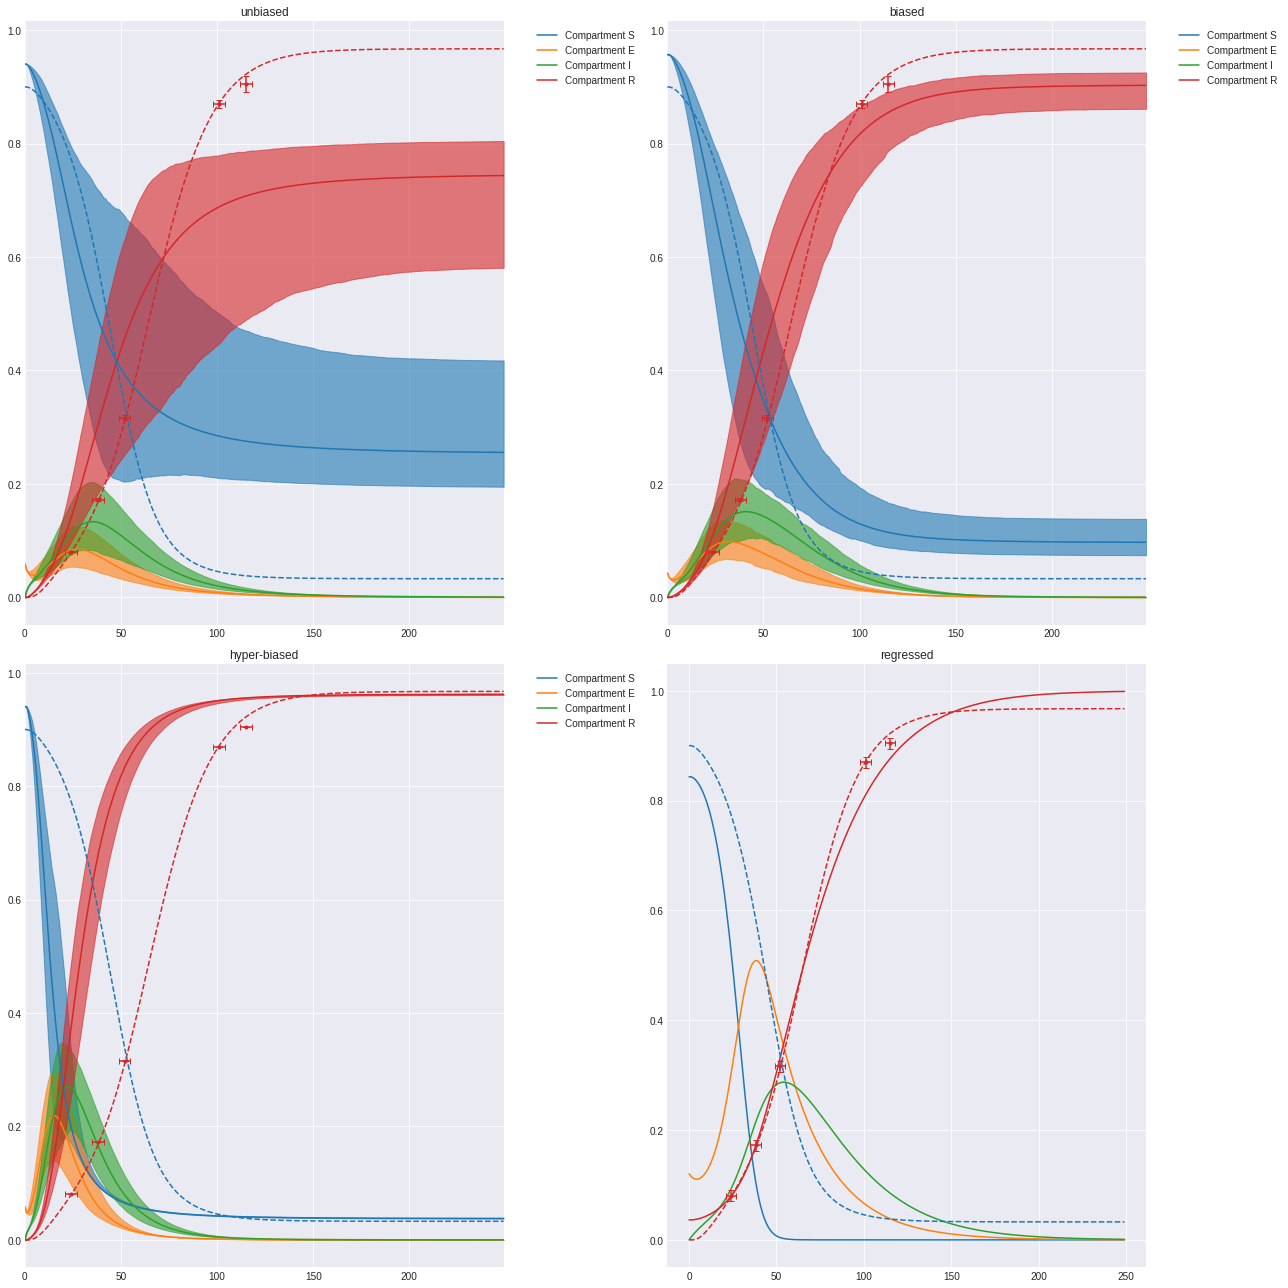

In [84]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18,18))
axs[0,0].set_title('unbiased')
maxentep.traj_quantile(trajs[:,:,0,:], names=full_compartments, ax=axs[0,0])
axs[0,0].plot(ref_traj[:,0,-1], linestyle='--', color='C3')
axs[0,0].plot(ref_traj[:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns):
    pf(axs[0,0], me_model.lambdas[i], color='C3')

axs[0,1].set_title('biased')
maxentep.traj_quantile(trajs[:,:,0,:], weights=me_model.traj_weights, names=full_compartments, ax=axs[0,1])
axs[0,1].plot(ref_traj[:,0,-1], linestyle='--', color='C3')
axs[0,1].plot(ref_traj[:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns):
    pf(axs[0,1], me_model.lambdas[i], color='C3')
plt.tight_layout()

axs[1,0].set_title('hyper-biased')
maxentep.traj_quantile(hme_model.trajs[:,:,0,:], weights=hme_model.traj_weights, names=full_compartments, ax=axs[1,0])
axs[1,0].plot(ref_traj[:,0,-1], linestyle='--', color='C3')
axs[1,0].plot(ref_traj[:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns):
    pf(axs[1,0], hme_model.lambdas[i], color='C3')
plt.tight_layout()

axs[1,1].set_title('regressed')
axs[1,1].plot(rtraj[0,:,0,:])
axs[1,1].plot(ref_traj[:,0,-1], linestyle='--', color='C3')
axs[1,1].plot(ref_traj[:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns):
    pf(axs[1,1], 1, color='C3')


## Other Patch

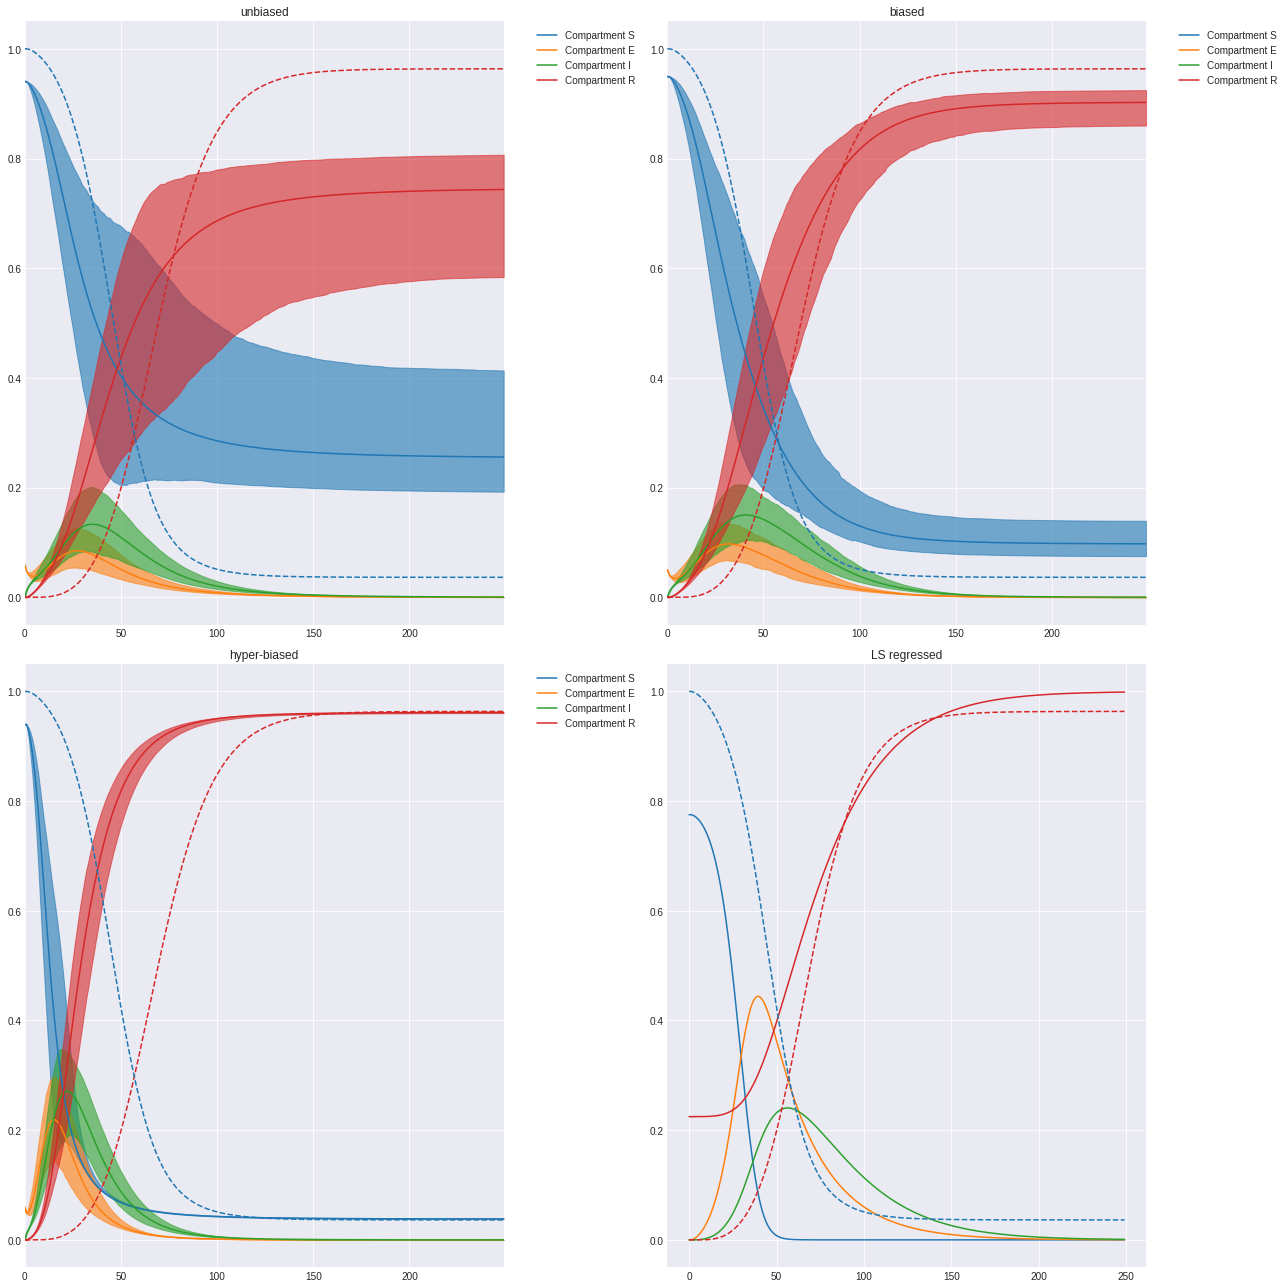

In [85]:
patch = 2
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18,18))
axs[0,0].set_title('unbiased')
maxentep.traj_quantile(trajs[:,:,patch,:], names=full_compartments, ax=axs[0,0])
axs[0,0].plot(ref_traj[:,patch,-1], linestyle='--', color='C3')
axs[0,0].plot(ref_traj[:,patch,0], linestyle='--', color='C0')

axs[0,1].set_title('biased')
maxentep.traj_quantile(trajs[:,:,patch,:], weights=me_model.traj_weights, names=full_compartments, ax=axs[0,1])
axs[0,1].plot(ref_traj[:,patch,-1], linestyle='--', color='C3')
axs[0,1].plot(ref_traj[:,patch,0], linestyle='--', color='C0')
plt.tight_layout()

axs[1,0].set_title('hyper-biased')
maxentep.traj_quantile(hme_model.trajs[:,:,patch,:], weights=hme_model.traj_weights, names=full_compartments, ax=axs[1,0])
axs[1,0].plot(ref_traj[:,patch,-1], linestyle='--', color='C3')
axs[1,0].plot(ref_traj[:,patch,0], linestyle='--', color='C0')
plt.tight_layout()

axs[1,1].set_title('LS regressed')
axs[1,1].plot(rtraj[0,:,patch,:])
axs[1,1].plot(ref_traj[:,patch,-1], linestyle='--', color='C3')
axs[1,1].plot(ref_traj[:,patch,0], linestyle='--', color='C0')

plt.tight_layout()